In [6]:
from dataclasses import dataclass
from typing import Any, List

from collections import namedtuple
from snake_egg import EGraph, Rewrite, Var, vars
import re
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import isomorphism
import json
import subprocess
import time
from collections import deque
from itertools import count

In [7]:
class Node:
    def __init__(self, name=None, bitwidth=None, operation=None, operands=None, 
                 idNum=None, value=-1, pos=None, FuncIO=None, start=None, width=None, array_sizes=None, indices=None):
        self.name = name
        self.bitwidth = bitwidth
        self.operation = operation
        self.operands = operands
        self.idNum = idNum
        self.value = value
        self.pos = pos
        self.FuncIO = FuncIO
        self.start = start
        self.width = width
        self.array_sizes = array_sizes
        self.indices = indices

    def __repr__(self):
        return f"Node(name={self.name}, bitwidth={self.bitwidth}, operation={self.operation}, operands={self.operands}, id={self.idNum}, value={self.value}, pos={self.pos}, FuncIO={self.FuncIO}, start={self.start}, width={self.width}, array_sizes={self.array_sizes}, indices={self.indices})"

def node_to_dict(node):
    return {
        "OperationName": node.name,
        "BitWidth": node.bitwidth,
        "OperationType": node.operation,
        "Operands": node.operands,
        "idNum": node.idNum,
        "Value": node.value,
        "Pos": node.pos,
        "FuncIO": node.FuncIO,
        "Start": node.start,
        "Width": node.width,
        "ArraySize": node.array_sizes,
        "Indices": node.indices
    }
    
def ParseIRFile(ir_text):
    nodes_dict = {}
    lines = ir_text.strip().split("\n")[:]
    return lines

def LineToDict(line):
    nodes = []
    # Check for function header
    FuncIO = "Not"
    if "fn" in line:
        FuncIO = "In"
        signature_pattern = re.compile(r"fn\s+(\w+)\((.*?)\)\s*->\s*(.*?)\s*\{")
        signature_match = signature_pattern.search(line)
        if signature_match:
            func_name = signature_match.group(1)
            params = signature_match.group(2).split(',')
            for param in params:
                param_name, param_type = param.split(':')
                param_name = param_name.strip()
                array_sizes = [int(size) for size in re.findall(r'\[(\d+)\]', param_type)]
                if array_sizes == []:
                    array_sizes = None
                bitwidth = int(array_sizes.pop(0))  # The first size is the bitwidth
                node = Node(name=param_name, bitwidth=bitwidth, array_sizes=array_sizes, FuncIO="In")
                nodes.append(node)
        return nodes

    if "ret" in line:
        FuncIO = "Out"
        line = line[4:]
        
    if line == "}":
        return None

    # Extract node name
    name = re.search(r"(\w+\.\d+):", line).group(1)

    # Extract bitwidth and array size
    array_pattern = re.compile(r"bits\[(\d+)\]((?:\[\d+\])*)")
    array_match = array_pattern.search(line)
    if array_match:
        bitwidth = int(array_match.group(1))
        array_sizes_str = array_match.group(2)
        array_sizes = [int(size) for size in re.findall(r'\[(\d+)\]', array_sizes_str)]
        if array_sizes == []:
            array_sizes = None
    
    # Extract operation
    operation = re.search(r"= (\w+)", line).group(1)

    # Extract operands; 
    # Eidt to ignore other argument keywords
    operands = re.findall(r"(\w+\.\d+|\w+)", line.split("=")[1])
    operands = [op for op in operands if op not in [operation, "value", "id", "pos", "start", "width", "indices"]]

    # Extract indices: only applies for array_indice node
    indices = None
    indices_match = re.search(r"indices=\[(.*?)\]", line)
    if indices_match:
        # Get the string of indices
        indices_str = indices_match.group(1)
        # Find all occurrences of literals or node names in the indices string
        indices = re.findall(r"(\w+\.\d+|\w+)", indices_str)
    
    # Extract id
    idNum = int(re.search(r"id=(\d+)", line).group(1))

    # Extract value (if present)
    value_match = re.search(r"value=(\d+)", line)
    value = int(value_match.group(1)) if value_match else -1

    # Extract pos (if present)
    pos_match = re.search(r"pos=\[\((\d+,\d+,\d+)\)\]", line)
    pos = tuple(map(int, pos_match.group(1).split(","))) if pos_match else None

    # Extract start and width for bit_slice (if present)
    start = None
    width = None
    if operation == "bit_slice":
        start = int(re.search(r"start=(\d+)", line).group(1))
        width = int(re.search(r"width=(\d+)", line).group(1))

    # Create Node object
    node = Node(name, bitwidth, operation, operands, idNum, value, pos, FuncIO, start, width, array_sizes, indices)
    
    # Add to node list
    nodes.append(node)
    return nodes

def DictToGraph(G, NodeDict):
    # This function turns the node dictionary to directional graph
    NodeList = []
    EdgeList = []
    for NodeName in NodeDict:
        if NodeDict[NodeName].FuncIO != "In": 
            # This if is for handling the function top input, they are treated as nodes as well.
            NodeList.append((NodeDict[NodeName].idNum, node_to_dict(NodeDict[NodeName])))
            for ParentName in NodeDict[NodeName].operands:
                if NodeDict[ParentName].FuncIO != "In":
                    EdgeList.append((NodeDict[ParentName].idNum, NodeDict[NodeName].idNum))
                else: 
                    EdgeList.append((NodeDict[ParentName].name, NodeDict[NodeName].idNum))
            if NodeDict[NodeName].indices != None:
                for ParentName in NodeDict[NodeName].indices:
                    if NodeDict[ParentName].FuncIO != "In":
                        EdgeList.append((NodeDict[ParentName].idNum, NodeDict[NodeName].idNum))
                    else: 
                        EdgeList.append((NodeDict[ParentName].name, NodeDict[NodeName].idNum))
        else:
            NodeList.append((NodeDict[NodeName].name, node_to_dict(NodeDict[NodeName])))

    G.add_nodes_from(NodeList)
    G.add_edges_from(EdgeList)
    return G
    
    
def slice_ir_by_function(ir_content):
    # Regular expression to match function definitions with and without "top"
    fn_pattern = re.compile(r"(?:top\s+)?fn\s+(\w+)\((.*?)\)\s*->\s*(.*?)\s*\{")

    # Split the content by lines for processing
    lines = ir_content.split('\n')

    # Dictionary to store each function's IR content
    functions_dict = {}

    # Buffer to store current function lines
    current_fn = None
    current_fn_lines = []

    # Iterate through each line
    for line in lines:
        # Check if the line starts a new function definition
        match = fn_pattern.match(line)
        if match:
            # If there is a current function being processed, save it
            if current_fn:
                functions_dict[current_fn] = '\n'.join(current_fn_lines)
                current_fn_lines = []
            # Start a new function
            current_fn = match.group(1)
        # Add the line to the current function's lines
        if current_fn:
            current_fn_lines.append(line)
        # Check if the line ends a function definition
        if line.strip() == '}':
            # Save the current function and reset
            if current_fn:
                functions_dict[current_fn] = '\n'.join(current_fn_lines)
                current_fn = None
                current_fn_lines = []

    # Return the dictionary with function names as keys and IR content as values
    return functions_dict



In [8]:
# Define the operations as named tuples
add = namedtuple("add", "x y")
sub = namedtuple("sub", "x y")
mul = namedtuple("mul", "x y")
div = namedtuple("div", "x y")
shll = namedtuple("shll", "x y")  # Bitshift left
shrl = namedtuple("shrl", "x y")  # Bitshift right
not_ = namedtuple("not_", "x")    # Bitwise NOT
neg = namedtuple("neg", "x")      # Negation

# Evaluation function
def eval_ops(car, cdr):
    try:
        if isinstance(car, (int, float)):
            return car

        if len(cdr) == 0:
            return None

        op = car
        args = cdr

        a = args[0]
        if op == not_:
            return ~a
        if op == neg:
            return -a

        b = args[1]
        if op == add:
            return a + b
        if op == sub:
            return a - b
        if op == mul:
            return a * b
        if op == div and b != 0:
            return a / b
        if op == shll:
            return a << b
        if op == shrl:
            return a >> b

    except:
        pass

    return None

# Rewrite rules
a, b, c = vars("a b c")  # Variables for rewrite rules

list_rules: List[List[Any]] = [
    # Basic arithmetic rules
    ["comm_add", add(a, b), add(b, a)],
    ["comm_mul", mul(a, b), mul(b, a)],
    ["zero_add", add(a, 0), a],
    ["zero_mul", mul(a, 0), 0],
    ["one_mul", mul(a, 1), a],
    ["sub_zero", sub(a, 0), a],
    ["neg", neg(a), sub(0, a)],

    # Bitwise rules
    ["shll_zero", shll(a, 0), a],
    ["shrl_zero", shrl(a, 0), a],
    ["not_not", not_(not_(a)), a],
    
    # DAC paper rules
    ["mul_associativity", mul(mul(a, b), c), mul(b, mul(a, c))],
    ["add_associativity", add(add(a, b), c), add(b, add(a, c))],
    ["mul_distributivity", mul(a, add(b, c)), add(mul(a, b), mul(a, c))],
    ["sum_same", add(a, a), mul(a, 2)],
    ["mul_sum_same", add(mul(a, b), b), mul(add(a, 1), b)],
    ["sub_to_neg", sub(a, b), add(a, neg(b))],
    ["mul_by_two", mul(a, 2), shll(a, 1)],
    ["merge_left_shift", shll(shll(a, b), c), shll(a, add(b, c))],
    ["merge_right_shift", shrl(shrl(a, b), c), shrl(a, add(b, c))],
    ["neg_to_not", neg(a), add(not_(a), 1)]
]

# Convert list rules into rewrites
rules = [Rewrite(frm, to, name) for name, frm, to in list_rules]

# Function to check if two expressions are equivalent
def is_equal(expr_a, expr_b, iters=5):
    egraph = EGraph(eval_bitwise_ops)
    id_a = egraph.add(expr_a)
    id_b = egraph.add(expr_b)
    egraph.run(rules, iters)
    return egraph.equiv(id_a, id_b)

def get_egraph_in_range(expr, min_iters=0, max_iters=50):
    expr_list = []
    last_iter_expr = None
    # Create an EGraph with the evaluation function
    egraph = EGraph(eval_ops)

    # Add the expression to the e-graph
    expr_id = egraph.add(expr)

    # Run the e-graph with the rewrite rules
    for cur_iters in range(min_iters, max_iters):
        egraph.run(rules, cur_iters)
        cur_expr = egraph.extract(expr_id)
        if last_iter_expr == cur_expr:
            break
        else:
            expr_list.append(cur_expr)
            last_iter_expr = cur_expr

    return expr_list

In [9]:
def remove_entries(operand_list, to_remove):
    return [op for op in operand_list if op not in to_remove]

def traverse_graph(G, start_node, processed_nodes):
# This function takes in a graph and partitions it to the largest legal rewrite batch
# If a node is not in the allowed list, it is discarded.
    allowed_operations = ["add", "umul", "smul", "literal", "shll", "shrl", "not", "neg", "sub", "udiv", "sdiv"]
    # Initialize the batch list
    batch = []

    # Create a set to keep track of visited nodes
    visited = set()

    # Traverse the graph
    stack = [start_node]
    while stack:
        current = stack.pop()
        current_op_type = G.nodes[current]['OperationType']

        # Check if the current node's operation is allowed
        if current_op_type in allowed_operations:
            # Add the current node to the batch and mark as visited
            batch.append(current)
            visited.add(current)

            for parent in G.predecessors(current):
                # Check if all children of the parent are either visited or disallowed
                all_children_allowed = all(
                    child in visited or G.nodes[child].get('OperationType', None) not in allowed_operations
                    for child in G.successors(parent)
                )

                if all_children_allowed and parent not in processed_nodes and parent not in visited:
                    stack.append(parent)
    if len(batch) == 1 and G.nodes[batch[0]]['OperationType'] == 'literal':
        batch = []
    return batch

def get_expr_from_batch(G, batch):
    N = len(batch)
    max_loop_count = N * (N + 1) // 2
    batch_queue = deque(batch)
    visited_dict = {}
    loop_count = 0
    cur_expr = None
    is_unsigned = True
    while batch_queue:
        cur_expr = None
        cur_node = batch_queue.pop()
        # If all operands are not in the batch waiting the be handled, or they have been vistied before
        if all(operand not in batch or operand in visited_dict for operand in G.nodes[cur_node]['Operands']):
            if G.nodes[cur_node]['OperationType'] == 'literal':
                visited_dict[G.nodes[cur_node]['OperationName']] = str(G.nodes[cur_node]['Value'])
            else:
                cur_expr = G.nodes[cur_node]['OperationType'] + "("
                for operand in G.nodes[cur_node]['Operands']:
                    # If the operand belongs to a processed expr, use it. Otherwise use the operand as string
                    if operand in visited_dict.keys():
                        cur_expr = cur_expr + visited_dict[operand] + ","
                    else:
                        cur_expr = cur_expr + "'" + operand + "'" + ","
                cur_expr = cur_expr[:-1] + ")"
                visited_dict[G.nodes[cur_node]['OperationName']] = cur_expr
            
            if G.nodes[cur_node]['OperationType'] in ["neg", "smul", "sdiv"]:
                is_unsigned = False
            
        else:
            batch_queue.appendleft(cur_node)
            
        if loop_count > max_loop_count:
            break
        else:
            loop_count += 1
    
    # Handle sign mapping, handle not mapping
    cur_expr = cur_expr.replace("umul", "mul").replace("smul", "mul")
    cur_expr = cur_expr.replace("udiv", "div").replace("sdiv", "div")
    cur_expr = cur_expr.replace("not", "not_")
    if len(batch_queue) == 0: 
        # Return the one with the most dependency
        return cur_expr, is_unsigned
    else:
        print("[ERROR] Unresolved dependency in batch to expr generation")
        return None, None
    
    return None, None

def gen_json_from_expr_recursive(G, expr, operation_mapping, bit_width, nodes_involved_dict=None, counter=None):
    if counter is None:
        counter = 0
    if nodes_involved_dict is None:
        nodes_involved_dict = {}
    
    match = re.search(r'\b(\w+)\(([^()]+)\)', expr)
    if not match:
        return nodes_involved_dict, counter-1

    operation_type, operands = match.groups()
    operation_name = 'auto_gen'+str(counter)

    # Replace the innermost expression with the placeholder
    new_expr = expr.replace(match.group(0), operation_name)
#     print("OpType: ", operation_type, "; Operands: ",operands)
#     print("Iter:", counter, "expr: ",new_expr)
    
    
    # Handle each node:
    nodes_involved_dict, counter = handle_node_generation(G, operation_type, operands, operation_name, bit_width, nodes_involved_dict, operation_mapping, counter)
    
    return gen_json_from_expr_recursive(G, new_expr, operation_mapping, bit_width, nodes_involved_dict, counter+1)


# Node(name=None, bitwidth=None, operation=None, operands=None, 
#                  idNum=None, value=None, pos=None, FuncIO=None, start=None, width=None)

def handle_node_generation(G, operation_type, operands, operation_name, bit_width, nodes_involved_dict, operation_mapping, counter):
    operands_list = operands.split(',')
    new_node_operands = []
    NewNode = None
    for cur_operand in operands_list:
        cur_operand = cur_operand.split("=")[-1]
        # First setup operand list
        if cur_operand.strip("'").strip(" ").isdigit():
            counter += 1
            # Handle pure digit, generate literal from them
            try:
                cur_value = int(cur_operand.strip("'").strip(" "))
            except ValueError:
                cur_value = float(cur_operand.strip("'").strip(" "))
            NewLiteralNode = node_to_dict(Node('auto_gen'+str(counter), bit_width, 'Literal', value=cur_value))
            NewLiteralNode["ReplaceSelfWith"] = 'Gen'       
            nodes_involved_dict['auto_gen'+str(counter)] = NewLiteralNode
            new_node_operands.append('auto_gen'+str(counter))
        else:
            new_node_operands.append(cur_operand.strip("'"))
    #Now generate new node:
    NewNode = node_to_dict(Node(operation_name, bit_width, operation_mapping[operation_type], new_node_operands))
    NewNode["ReplaceSelfWith"] = 'Gen'
    nodes_involved_dict[operation_name] = NewNode
    return nodes_involved_dict, counter


In [10]:
def gen_json_from_ir(ir_input_path, json_output_path, rewrite_rule = "NoRule"):
    # This function takes in ir file and generate json instruction based on e-graph
    
    TopFunctionName = None
    with open(ir_input_path, 'r') as f:
        ir_content = f.read()
        ir_dict = slice_ir_by_function(ir_content)

    #     print(ir_content)

    FuncNodeDict = {}
    for fn_name, fn_content in ir_dict.items():
        NodeDict = {}
        Lines = ParseIRFile(fn_content)
        for Line in Lines:    
            NodeList = LineToDict(Line)
            if NodeList != None:
                for NodeObj in NodeList:
                    NodeDict[NodeObj.name] = NodeObj
            if "top" in Line:
                TopFunctionName = fn_name
        FuncNodeDict[fn_name] = NodeDict
    SubCounter = 0
    NodeCounter = 0
    JsonOutDict = {}
    # print(FuncNodeDict)


    ## The following code reads digraph and partitions them into legal rewrite batches
    graph_by_function = {}
    sorted_nodes_by_function = {}

    for fn_name, fn_nodes in FuncNodeDict.items():
        G = nx.DiGraph()
        G = DictToGraph(G, fn_nodes)
        graph_by_function[fn_name] = G
        nx.draw(G, with_labels=True, font_weight='bold')
        # Check if the graph is a DAG
        if nx.is_directed_acyclic_graph(G):
            sorted_nodes = list(nx.topological_sort(G))
            sorted_nodes_by_function[fn_name] = sorted_nodes[::-1]
        else:
            sorted_nodes_by_function[fn_name] = None
            print(f"[Warning] Graph for function {fn_name} is not a DAG. Topological sorting cannot be performed.")
#         print(f"Function: {fn_name}")
#         print("Batches of nodes:", sorted_nodes_by_function[fn_name])   


    rewrite_batch_by_function = {}
    processed_nodes = set()

    for fn_name, nodes in sorted_nodes_by_function.items():
        G = graph_by_function[fn_name]
        rewrite_batch_by_function[fn_name] = []

        temp_nodes = nodes.copy()
        while temp_nodes:
            start_node = temp_nodes[0]
            cur_batch = traverse_graph(G, start_node, processed_nodes)
            if cur_batch != []:
                rewrite_batch_by_function[fn_name].append(cur_batch)
                for node in cur_batch:
                    processed_nodes.add(node)
                    if node in temp_nodes:
                        temp_nodes.remove(node)
            else:
                break

        print(f"Function: {fn_name}")
        print("Batches of nodes:", rewrite_batch_by_function[fn_name])

    ## The following code takes each batch, and generate expression for e-graph search
    rewrite_candidate_by_function = {}
    for fn_name, batch_list in rewrite_batch_by_function.items():
        G = graph_by_function[fn_name]
        rewrite_candidate_by_function[fn_name] = {}
        rewrite_candidate_by_function[fn_name]['is_unsigned'] = []
        rewrite_candidate_by_function[fn_name]['rewrite_candidates'] = []
        for batch in batch_list:
            batch_expr, is_unsigned = get_expr_from_batch(G, batch)
#             print("FunctionName: ", fn_name,"Input Expr: ", batch_expr)
            cur_candidates = get_egraph_in_range(eval(batch_expr))
            rewrite_candidate_by_function[fn_name]['is_unsigned'].append(is_unsigned)
            rewrite_candidate_by_function[fn_name]['rewrite_candidates'] .append(cur_candidates)

    # print(rewrite_candidate_by_function)

    operation_mapping_unsigned = {"add" : "kAdd",
                                  "mul" : "kUMul",
                                  "div" : "kUDiv",
                                  "sub" : "kSub",
                                "literal" : "Literal",
                                 "neg" : "kNeg",
                                 "shll" : "kShll",
                                 "shrl" : "kShrl",
                                 "not_" : "kNot"}

    operation_mapping_signed = {"add" : "kAdd",
                                  "mul" : "kSMul",
                                  "div" : "kSDiv",
                                  "sub" : "kSub",
                                "literal" : "Literal",
                                 "neg" : "kNeg",
                                 "shll" : "kShll",
                                 "shrl" : "kShrl",
                                 "not_" : "kNot"}
    json_dict = {}
    counter = 0
    for fn_name, all_rewrite_candidates_dict in rewrite_candidate_by_function.items():
        G = graph_by_function[fn_name]
        for i in range(len(all_rewrite_candidates_dict['rewrite_candidates'])):
            cur_rewrite_candidate = all_rewrite_candidates_dict['rewrite_candidates'][i]
            # This is where we call our selector to get a best rewrite
            if rewrite_rule == "NoRule":
                rewrite_expr = cur_rewrite_candidate[-1]
            else:
                pass
            
#             print("FunctionName: ",fn_name, "\nRewrite Expr", rewrite_expr)
            
            #After getting the wanted rewrite_expr, we apply it and generate json dict
            #First we initialize the dictionary
            json_dict[str(counter)] = {}
            json_dict[str(counter)]["FuncName"] = fn_name

            #Then, find bitwidth and if the variables are signed, and assign operator mapping
            cur_is_unsigned = all_rewrite_candidates_dict['is_unsigned'][i]
            bit_width = G.nodes[rewrite_batch_by_function[fn_name][i][0]]['BitWidth']
            if cur_is_unsigned:
                cur_operation_mapping = operation_mapping_unsigned
            else:
                cur_operation_mapping = operation_mapping_signed
            #Next, handle node generation
            nodes_involved_dict, batch_out_counter = gen_json_from_expr_recursive(G, str(rewrite_expr), cur_operation_mapping, bit_width)

            #Next, handle node elimination
            for old_node_id in rewrite_batch_by_function[fn_name][i]:
                nodes_involved_dict[G.nodes[old_node_id]['OperationName']] = G.nodes[old_node_id]
                nodes_involved_dict[G.nodes[old_node_id]['OperationName']]['ReplaceSelfWith'] = 'Kill'

            #Next, handle batch output replacement
            #ToDo: we need to verify the first is always the output of the batch
            nodes_involved_dict[G.nodes[rewrite_batch_by_function[fn_name][i][0]]['OperationName']] = G.nodes[rewrite_batch_by_function[fn_name][i][0]]
            nodes_involved_dict[G.nodes[rewrite_batch_by_function[fn_name][i][0]]['OperationName']]['ReplaceSelfWith'] = 'auto_gen'+str(batch_out_counter)

            json_dict[str(counter)]["NodesInvolved"] = list(nodes_involved_dict.values())
            counter += 1
            
    #         print(nodes_involved_dict)

    with open(json_output_path, 'w') as json_file:
            json.dump(json_dict, json_file, indent=4)  
    return TopFunctionName

Function: AddAssociativity
Batches of nodes: [[2, 1]]
Function: Unsigned_MulAssociativity
Batches of nodes: [[4, 3]]
Function: MulDistribution
Batches of nodes: [[6, 5]]
Function: SumSame
Batches of nodes: [[7]]
Function: MulSumSame
Batches of nodes: [[11, 10], [9, 8]]
Function: Signed_MulAssociativity
Batches of nodes: [[13, 12]]
Function: SubToNeg
Batches of nodes: [[14]]
Function: MulByTwo
Batches of nodes: [[18, 17], [16, 15]]
Function: MergeLeftRightShift
Batches of nodes: [[22, 21], [20, 19]]
Function: NegToNot
Batches of nodes: [[24]]
Function: NotOverConcat
Batches of nodes: [[26]]
Function: CoreDump
Batches of nodes: [[29, 28, 27]]


'AddAssociativity'

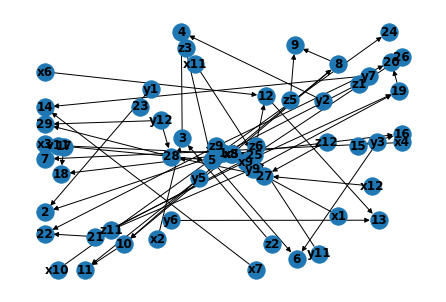

In [11]:
gen_json_from_ir("/home/miao/xls/work_space/EGraphUnitTest/all_unit_test.ir", "/home/miao/xls/work_space/EGraphUnitTest/all_unit_test.json")